In [1]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (481/481), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 481 (delta 365), reused 417 (delta 301), pack-reused 0
Receiving objects: 100% (481/481), 2.93 MiB | 1.87 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [2]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
from Eunomia.ssb import * 
from Eunomia.graph_utils import * 
from itertools import combinations
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
pyro.set_rng_seed(1)
import itertools
import random
import networkx as nx
from torch.distributions.bernoulli import Bernoulli

pairs = lambda E:list(combinations(E, 2))


def sample_bernoulli(p, n):
    """
    Samples from a Bernoulli distribution.

    Args:
    p (float): Probability of success (1) in each Bernoulli trial.
    n (int): Number of samples to draw.

    Returns:
    torch.Tensor: A tensor of shape (n,) with samples from the Bernoulli distribution.
    """
    dist = Bernoulli(torch.tensor([p]))
    samples = dist.sample([n]).squeeze()
    return samples

class SSBModel(nn.Module):
    """
    A PyTorch module implementing the Symmetric Skew Bilinear (SSB) model.

    This model combines additive and non-transitive interactions to assess preferences between alternatives.

    Attributes:
        theta (list): A list of attributes or interactions considered by the model.
        weights (torch.nn.Parameter): A parameter vector for the additive part of the model.
        phi_function (PhiFunction): An instance of PhiFunction to handle non-transitive interactions.

    Methods:
        logprior(lambda_1, lambda_2): Computes the regularization term for the model.
        likelihood(R): Computes the likelihood of the preference data.
        forward(sparse_X, sparse_Y): Computes the utility score for a pair of alternatives.
        accuracy(s): Computes the accuracy of the model on a dataset.
        display_model(): Displays the model parameters.
    """

    def __init__(self, theta):
        """
        Initializes the SSBModel module.

        Parameters:
            theta (list): A list of attributes or interactions considered by the model.
        """
        super(SSBModel, self).__init__()
        self.theta = theta
        self.weights = nn.Parameter(torch.randn(len(theta)))
        self.phi_function = PhiFunction(theta)
        
        
    def logprior(self, lambda_1, lambda_2):
        """
        Computes the regularization term for the model, combining the L2 norm of the weights and the regularization of the phi function parameters.
    
        The regularization term is given by:
        \lambda_1 \cdot \sum \text{weights}^2 + \lambda_2 \cdot \text{phi_function.logprior()}
    
        Here, \lambda_1 and \lambda_2 are regularization parameters that control the extent of regularization for the weights and phi function parameters, respectively.
    
        Parameters:
            lambda_1 (float): Regularization parameter for the weights.
            lambda_2 (float): Regularization parameter for the phi function.
    
        Returns:
            torch.tensor: The combined regularization term.
        """
        return lambda_1 * torch.sum(torch.pow(self.weights, 2)) + lambda_2 * self.phi_function.logprior()



    def likelihood(self, R):
        """
        Computes the likelihood of the preference data using a sigmoid function.
    
        For each pair of alternatives (X, Y) in R, this method computes the utility score f(X, Y) using the forward method. 
        The likelihood is then calculated as the sum of the sigmoid of these utility scores.
    
        The sigmoid function is used to transform the utility score into a probability between 0 and 1, reflecting 
        the probability of preferring X over Y.
    
        The formula for likelihood is given by:
        L(R) = \sum_{(X, Y) \in R} \sigma(f(X, Y))
        where \sigma is the sigmoid function, and f(X, Y) is the utility score for the pair (X, Y).
    
        Parameters:
            R (list): A list of pairs of alternatives.
    
        Returns:
            torch.tensor: The likelihood value.
        """
        l = torch.tensor(0).float()
        for sparse_X, sparse_Y in R:
            f = self.forward(sparse_X, sparse_Y).float()
            l += torch.sigmoid(f)
        return l

    def forward(self, sparse_X, sparse_Y):
        """
        Computes the utility score for a pair of alternatives X and Y.

        Parameters:
            sparse_X (list): A sparse representation of alternative X.
            sparse_Y (list): A sparse representation of alternative Y.

        Returns:
            torch.tensor: The utility score for the pair (X, Y).
        """
        f = 0
        for S in self.theta:
            if all(i in sparse_X for i in S):
                f += self.weights[self.theta.index(S)]
            if all(i in sparse_Y for i in S):
                f -= self.weights[self.theta.index(S)]
        f += self.phi_function(sparse_X, sparse_Y)
        return f

    def accuracy(self, s):
        """
        Computes the accuracy of the model on a dataset.

        Parameters:
            s (list): A list of pairs of alternatives along with their actual preference.

        Returns:
            float: The accuracy of the model.
        """
        L = []
        for x, y in s:
            f = self.forward(x, y)
            L.append(1 if f > 0 else 0)
        return np.mean(L)

    def display_model(self):
        """
        Displays the model parameters.
        """
        for i in range(self.weights.shape[0]):
            if np.abs(self.weights[i].detach().numpy()) > 1e-5:
                print(f"w[{i}] = {self.weights[i]}")
        for (i, j, A, B) in self.phi_function.phi_values: 
            if np.abs(self.phi_function.phi_values[(i, j, A, B)].item()) > 1e-5:
                print(f"C[{i}, {j}, {A}, {B}] = {self.phi_function.phi_values[(i, j, A, B)].item()}", end=" \n")

In [3]:
class SSB_Sampler():
    
    def __init__(self, n,k):
        self.theta = [tuple(i) for i in generate_additive_theta(n, k)]
        self.model = SSBModel(self.theta)
        self.masque_theta = None
        self.masque_phi = None
        
    def resample(self, p_1=0.5, p_2=0.5):
        self.masque_theta = []
        self.masque_phi = []
        phi_params = {k:self.model.phi_function.phi_values[k] for k in self.model.phi_function.phi_values}
        self.masque_theta = sample_bernoulli(p_1, len(self.theta))
        self.model.weights = nn.Parameter(torch.randn(len(self.theta))*self.masque_theta)
        for k in phi_params:
            m = sample_bernoulli(p_2, 1).item()
            self.model.phi_function.phi_values[k] = nn.Parameter(torch.randn(1)[0] * m)
            self.masque_phi.append(m)
        #print("inf : ", p_2 , " phi  = ", self.masque_phi)
            
        return np.array(self.masque_theta), np.array(self.masque_phi)
    
    def __call__(self,x,y):
        return self.model(x,y)
    
    
class SSB_Decider():
    
    def __init__(self, ground_truth):
        self.ground_truth = ground_truth
        self.alternatives = []
        self.preferences = []
        
    def __call__(self, x, y):
        if self.ground_truth(x,y) > 0 :
            self.preferences.append((x,y))
        if self.ground_truth(x,y) < 0 :
            self.preferences.append((y,x))
        return self.ground_truth(x,y)
    
    def relation(self):
        return self.preferences
        
        

In [4]:
def sample_full_relation(n,k, p_1 = 0.6, p_2 = 0.6):
    sampler = SSB_Sampler(n,k)
    decider = SSB_Decider(sampler)
    mt,mp = sampler.resample(p_1 = p_1, p_2 = p_2)
    for x,y in pairs(sampler.theta):
        decider(x,y)
    return decider.relation(), mt, mp, sampler

In [5]:
sample_full_relation(3,1)

([((0,), (1,)), ((2,), (0,)), ((2,), (1,))],
 array([1., 1., 0.], dtype=float32),
 array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.]),
 <__main__.SSB_Sampler at 0x7fd4529cca90>)

In [6]:
sample_bernoulli(0.1, 1).item()

0.0

In [25]:
import time
data = {
    "additive_acc":[],
    "nt_acc":[],
    "s_time":[],
    "s_fit_w":[],
    "s_fit_M":[],
    "mt":[],
    "mp":[],
    "n":[],
}
n_exps = 20
n_epochs = 50

lambda_1 = 0
lambda_2 = 0

for n in range(4,6):
    for k in range(2,3):
        for p in np.linspace(0,1,10):
            for exp in trange(n_exps):
                L = []
                nb = 0
                t = time.time()
                s, mt, mp, sampler = sample_full_relation(n,k, p_1 = 1.0, p_2 = 0.5)
                s_time = time.time() - t
                
                
                model_map = SSBModel(sampler.theta)
                
                t = time.time()
                acc1 = fit_w_map(model_map, s, num_epochs=n_epochs,  lr=5e-2, lambda_1 = lambda_1)
                s_fit_w = time.time() - t
                
                t = time.time()
                acc2 = fit_M_map(model_map, s, num_epochs=n_epochs, lr=5e-2, lambda_2 = lambda_2)
                s_fit_M = time.time() - t
                acc = acc1 + acc2
                
                
                data["s_time"].append(s_time)
                data["s_fit_w"].append(s_fit_w)
                data["s_fit_M"].append(s_fit_M)
            
                data["mp"].append(mp.sum())
                data["mt"].append(mt.sum())
                data["n"].append(n)
                #print("p = ", p, "mp = ", mp.sum())
        
                data["additive_acc"].append(max(acc1))
                data["nt_acc"].append(max(acc2))
                
                L.append(max(acc2) - max(acc1))
            print(pd.DataFrame(data).groupby(["n", "mp"]).mean())

  0%|          | 0/20 [00:00<?, ?it/s]

        additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                            
4 76.0      0.800000     1.0  0.071262  2.223686  2.455737  10.0
  77.0      0.933333     1.0  0.072297  2.130782  2.403260  10.0
  82.0      0.822222     1.0  0.070366  2.133780  2.533299  10.0
  83.0      0.866667     1.0  0.068618  2.189944  2.492960  10.0
  85.0      0.822222     1.0  0.071254  2.173148  2.448044  10.0
  87.0      0.911111     1.0  0.077054  2.152534  2.767557  10.0
  89.0      0.800000     1.0  0.069386  2.173538  2.833253  10.0
  90.0      0.896296     1.0  0.072051  2.147294  2.477163  10.0
  91.0      0.711111     1.0  0.077720  2.191807  2.504888  10.0
  92.0      0.888889     1.0  0.069059  2.190526  2.437455  10.0
  93.0      0.866667     1.0  0.070038  2.117127  2.432346  10.0
  94.0      0.800000     1.0  0.073789  2.146643  2.462441  10.0
  95.0      0.755556     1.0  0.132136  2.150348  2.474188  10.0
  97.0      0.822222     

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 76.0       0.844444     1.0  0.071419  2.356844  2.534811  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  80.0       0.711111     1.0  0.073197  2.015096  2.355141  10.0
  81.0       0.777778     1.0  0.072010  2.236327  2.785431  10.0
  82.0       0.822222     1.0  0.070366  2.133780  2.533299  10.0
  83.0       0.792593     1.0  0.081767  2.410519  2.651831  10.0
  85.0       0.822222     1.0  0.071254  2.173148  2.448044  10.0
  87.0       0.888889     1.0  0.073321  2.124606  2.511902  10.0
  88.0       0.955556     1.0  0.077848  2.293026  2.475533  10.0
  89.0       0.792593     1.0  0.077027  2.269250  2.665970  10.0
  90.0       0.896296     1.0  0.072051  2.147294  2.477163  10.0
  91.0       0.800000     1.0  0.082878  2.308639  2.508533  10.0
  92.0       0.814815     1.0  0.070203  2.201061  2.576246  10.0
  93.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.844444     1.0  0.071419  2.356844  2.534811  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  80.0       0.711111     1.0  0.073197  2.015096  2.355141  10.0
  81.0       0.822222     1.0  0.070142  2.238325  2.552577  10.0
  82.0       0.911111     1.0  0.069956  2.160197  2.469480  10.0
  83.0       0.844444     1.0  0.088130  2.345858  2.649951  10.0
  85.0       0.822222     1.0  0.071254  2.173148  2.448044  10.0
  86.0       0.733333     1.0  0.078977  2.443290  2.845090  10.0
  87.0       0.855556     1.0  0.071163  2.133144  2.479194  10.0
  88.0       0.888889     1.0  0.075602  2.368153  2.526278  10.0
  89.0       0.792593     1.0  0.077027  2.269250  2.665970  10.0
  90.0       0.896296     1.0  0.072051  2.147294  2.477163  10.0
  91.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.866667     1.0  0.074514  2.342601  2.522699  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  80.0       0.711111     1.0  0.073197  2.015096  2.355141  10.0
  81.0       0.822222     1.0  0.070142  2.238325  2.552577  10.0
  82.0       0.888889     1.0  0.072196  2.149542  2.473797  10.0
  83.0       0.844444     1.0  0.088130  2.345858  2.649951  10.0
  85.0       0.831111     1.0  0.083453  2.259799  2.574250  10.0
  86.0       0.770370     1.0  0.078388  2.349969  2.706864  10.0
  87.0       0.840000     1.0  0.071639  2.130549  2.474328  10.0
  88.0       0.888889     1.0  0.075602  2.368153  2.526278  10.0
  89.0       0.792593     1.0  0.077027  2.269250  2.665970  10.0
  90.0       0.896296     1.0  0.072051  2.147294  2.477163  10.0
  91.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.866667     1.0  0.074514  2.342601  2.522699  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  79.0       0.733333     1.0  0.073594  2.195030  2.483091  10.0
  80.0       0.711111     1.0  0.073197  2.015096  2.355141  10.0
  81.0       0.829630     1.0  0.069225  2.232944  2.533383  10.0
  82.0       0.866667     1.0  0.072284  2.204914  2.529859  10.0
  83.0       0.844444     1.0  0.088130  2.345858  2.649951  10.0
  84.0       0.811111     1.0  0.073447  2.196830  2.434060  10.0
  85.0       0.831111     1.0  0.083453  2.259799  2.574250  10.0
  86.0       0.772222     1.0  0.076642  2.246230  2.578290  10.0
  87.0       0.853968     1.0  0.071676  2.143882  2.474039  10.0
  88.0       0.874074     1.0  0.074285  2.318075  2.521092  10.0
  89.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.866667     1.0  0.074514  2.342601  2.522699  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.733333     1.0  0.073594  2.195030  2.483091  10.0
  80.0       0.844444     1.0  0.072085  1.972112  2.270818  10.0
  81.0       0.829630     1.0  0.069225  2.232944  2.533383  10.0
  82.0       0.866667     1.0  0.072284  2.204914  2.529859  10.0
  83.0       0.844444     1.0  0.088130  2.345858  2.649951  10.0
  84.0       0.794444     1.0  0.071727  2.111546  2.340492  10.0
  85.0       0.828571     1.0  0.078472  2.172964  2.472557  10.0
  86.0       0.786667     1.0  0.075784  2.181952  2.503340  10.0
  87.0       0.850000     1.0  0.071014  2.116086  2.471358  10.0
  88.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.733333     1.0  0.073594  2.195030  2.483091  10.0
  80.0       0.844444     1.0  0.072085  1.972112  2.270818  10.0
  81.0       0.811111     1.0  0.067783  2.150882  2.452698  10.0
  82.0       0.855556     1.0  0.070730  2.173758  2.486476  10.0
  83.0       0.838095     1.0  0.085165  2.287534  2.593865  10.0
  84.0       0.794444     1.0  0.071727  2.111546  2.340492  10.0
  85.0       0.822222     1.0  0.075554  2.119727  2.429838  10.0
  86.0       0.786667     1.0  0.075784  2.181952  2.503340  10.0
  87.0       0.834568     1.0  0.070585  2.099209  2.448814  10.0
  88.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.788889     1.0  0.072734  2.086613  2.354135  10.0
  80.0       0.844444     1.0  0.072085  1.972112  2.270818  10.0
  81.0       0.811111     1.0  0.067783  2.150882  2.452698  10.0
  82.0       0.847619     1.0  0.066391  2.041592  2.330674  10.0
  83.0       0.838095     1.0  0.085165  2.287534  2.593865  10.0
  84.0       0.808889     1.0  0.073131  2.105579  2.435071  10.0
  85.0       0.822222     1.0  0.075554  2.119727  2.429838  10.0
  86.0       0.786667     1.0  0.075784  2.181952  2.503340  10.0
  87.0       0.846296     1.0  0.072265  2.140345  2.480928  10.0
  88.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.933333     1.0  0.072297  2.130782  2.403260  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
  80.0       0.844444     1.0  0.072085  1.972112  2.270818  10.0
  81.0       0.822222     1.0  0.060126  1.984317  2.284282  10.0
  82.0       0.847619     1.0  0.066391  2.041592  2.330674  10.0
  83.0       0.838095     1.0  0.085165  2.287534  2.593865  10.0
  84.0       0.818519     1.0  0.068627  1.988123  2.307593  10.0
  85.0       0.828889     1.0  0.073072  2.045522  2.353927  10.0
  86.0       0.786667     1.0  0.075784  2.181952  2.503340  10.0
  87.0       0.846296     1.0  0.072265  2.140345  2.480928  10.0
  88.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
  80.0       0.844444     1.0  0.072085  1.972112  2.270818  10.0
  81.0       0.822222     1.0  0.060126  1.984317  2.284282  10.0
  82.0       0.841667     1.0  0.064693  1.964273  2.238662  10.0
  83.0       0.827778     1.0  0.081067  2.182367  2.481589  10.0
  84.0       0.828571     1.0  0.068254  1.980734  2.294690  10.0
  85.0       0.824242     1.0  0.072203  2.044472  2.354794  10.0
  86.0       0.786667     1.0  0.075784  2.181952  2.503340  10.0
  87.0       0.855556     1.0  0.071167  2.075254  2.415704  10.0
  88.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w    s_fit_M    mt
n mp                                                              
4 72.0       0.777778     1.0  0.069166  2.310312   2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373   2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237   2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760   2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956   2.025114  10.0
  80.0       0.844444     1.0  0.072085  1.972112   2.270818  10.0
  81.0       0.822222     1.0  0.060126  1.984317   2.284282  10.0
  82.0       0.841667     1.0  0.064693  1.964273   2.238662  10.0
  83.0       0.827778     1.0  0.081067  2.182367   2.481589  10.0
  84.0       0.828571     1.0  0.068254  1.980734   2.294690  10.0
  85.0       0.824242     1.0  0.072203  2.044472   2.354794  10.0
  86.0       0.786667     1.0  0.075784  2.181952   2.503340  10.0
  87.0       0.855556     1.0  0.071167  2.075254   2.415704  

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
  80.0       0.844444     1.0  0.072085  1.972112  2.270818  10.0
  81.0       0.822222     1.0  0.060126  1.984317  2.284282  10.0
  82.0       0.841667     1.0  0.064693  1.964273  2.238662  10.0
  83.0       0.827778     1.0  0.081067  2.182367  2.481589  10.0
  84.0       0.828571     1.0  0.068254  1.980734  2.294690  10.0
  85.0       0.824242     1.0  0.072203  2.044472  2.354794  10.0
  86.0       0.786667     1.0  0.075784  2.181952  2.503340  10.0
  87.0       0.855556     1.0  0.071167  2.075254  2.415704  10.0
  88.0    

  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 224.0      0.844444     1.0  0.230958  8.797004  9.618355  15.0
  225.0      0.676190     1.0  0.239209  8.770037  9.544320  15.0
  227.0      0.733333     1.0  0.234436  8.805972  9.698023  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  233.0      0.780952     1.0  0.231369  8.865826  9.521674  15.0

[63 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 225.0      0.676190     1.0  0.239209  8.770037  9.544320  15.0
  227.0      0.733333     1.0  0.234436  8.805972  9.698023  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.809524     1.0  0.234623  8.733480  9.476573  15.0
  233.0      0.780952     1.0  0.231369  8.865826  9.521674  15.0

[68 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 227.0      0.733333     1.0  0.234436  8.805972  9.698023  15.0
  228.0      0.866667     1.0  0.231724  8.739720  9.628703  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.809524     1.0  0.234623  8.733480  9.476573  15.0
  233.0      0.780952     1.0  0.231369  8.865826  9.521674  15.0

[70 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 228.0      0.885714     1.0  0.232215  8.734880  9.589603  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.809524     1.0  0.234623  8.733480  9.476573  15.0
  232.0      0.752381     1.0  0.228234  8.739243  9.499453  15.0
  233.0      0.771429     1.0  0.231972  8.780958  9.578938  15.0

[74 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 228.0      0.885714     1.0  0.232215  8.734880  9.589603  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.809524     1.0  0.234623  8.733480  9.476573  15.0
  232.0      0.752381     1.0  0.228234  8.739243  9.499453  15.0
  233.0      0.771429     1.0  0.231972  8.780958  9.578938  15.0

[74 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 228.0      0.885714     1.0  0.232215  8.734880  9.589603  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.852381     1.0  0.240105  8.799266  9.544496  15.0
  232.0      0.752381     1.0  0.228234  8.739243  9.499453  15.0
  233.0      0.771429     1.0  0.231972  8.780958  9.578938  15.0

[76 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 228.0      0.911111     1.0  0.234759  8.726092  9.554688  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.852381     1.0  0.240105  8.799266  9.544496  15.0
  232.0      0.752381     1.0  0.228234  8.739243  9.499453  15.0
  233.0      0.771429     1.0  0.231972  8.780958  9.578938  15.0

[76 rows x 6 columns]


  0%|          | 0/20 [00:00<?, ?it/s]

         additive_acc  nt_acc    s_time   s_fit_w   s_fit_M    mt
n mp                                                             
4 72.0       0.777778     1.0  0.069166  2.310312  2.731437  10.0
  76.0       0.833333     1.0  0.073820  2.234373  2.449898  10.0
  77.0       0.844444     1.0  0.062700  1.807237  2.010468  10.0
  78.0       0.888889     1.0  0.068012  1.962760  2.289074  10.0
  79.0       0.814815     1.0  0.062121  1.797956  2.025114  10.0
...               ...     ...       ...       ...       ...   ...
5 228.0      0.911111     1.0  0.234759  8.726092  9.554688  15.0
  230.0      0.847619     1.0  0.233955  8.788457  9.649868  15.0
  231.0      0.838095     1.0  0.238196  8.813642  9.615114  15.0
  232.0      0.752381     1.0  0.228234  8.739243  9.499453  15.0
  233.0      0.796825     1.0  0.234704  8.752427  9.561274  15.0

[76 rows x 6 columns]


In [26]:
df = pd.DataFrame(data)
df["gain"] = df["nt_acc"] - df["additive_acc"]
df["mp"] = df["mp"] // 10
df["mp"] = df["mp"] * 10

<AxesSubplot:xlabel='mp', ylabel='gain'>

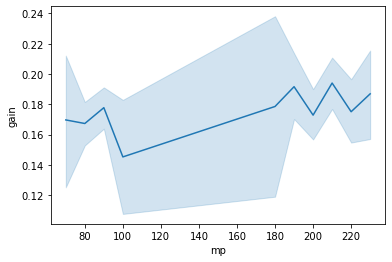

In [27]:
sns.lineplot(data = df, x = "mp", y = "gain")